In [1]:
# PART A: PARTICLE TRACKING
from __future__ import division, unicode_literals, print_function # for compatibility with Python 2 and 3
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import os
from pandas import DataFrame, Series # for convenience
import pims
import trackpy as tp


# Optionally, tweak styles.
mpl.rc('figure', figsize=(10, 5))
mpl.rc('image', cmap='gray')

@pims.pipeline
def gray(image):
    return image[:, :, 1] # Take just the green channel

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


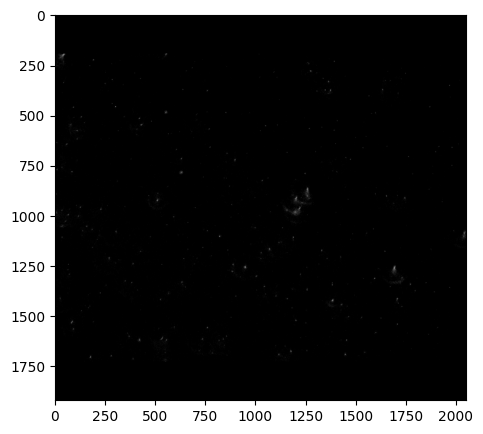

In [2]:
frames = gray(pims.Video('B1.avi'))
print(frames[0])
plt.imshow(frames[0])

            y            x          mass       size       ecc      signal  \
0  197.565276   551.688602   6202.432725   7.726869  0.319876   95.615111   
1  196.869643  1019.016071    334.652888  10.169984  0.673747   19.720617   
2  204.334771    36.037834  27704.478382  11.493758  0.318000  138.641911   
3  208.982301  1624.141593     67.528172  17.187668  0.989134    3.585567   
4  229.334689   187.345962   3233.583532  14.260292  0.833246   90.236761   

   raw_mass   ep  frame  
0    7473.0  0.0      0  
1     494.0  0.0      0  
2   39493.0  0.0      0  
3     149.0  0.0      0  
4    3673.0  0.0      0  


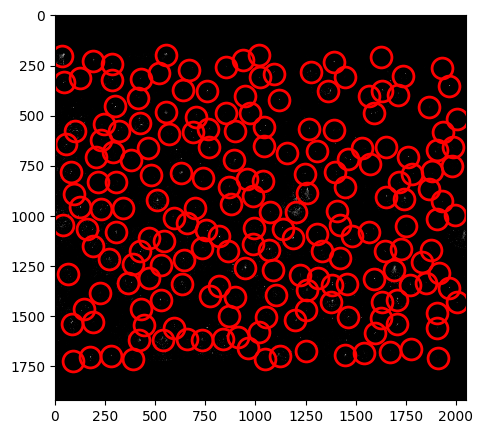

<Axes: >

In [3]:
# STEP 2: LOCATE FEATURES
f = tp.locate(frames[0], 69)
print(f.head()) # See top rows and columns for frame 0
plt.figure()
tp.annotate(f, frames[0])

The minimum value of mass is: 25.098966609814205


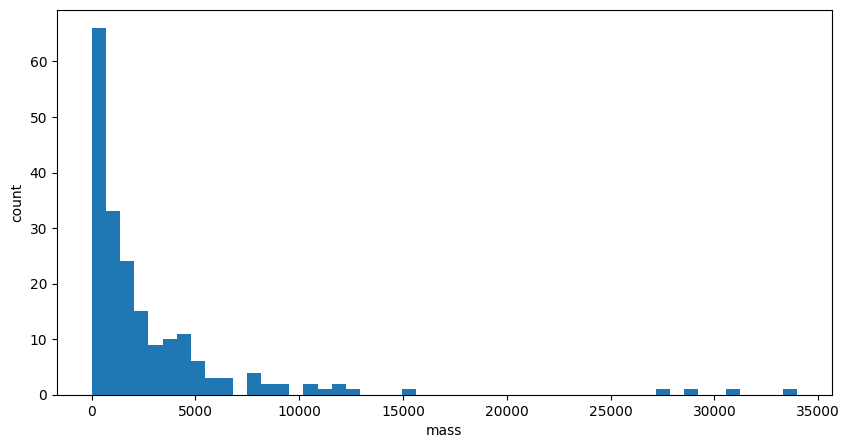

In [4]:
# Diagnostics
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=50)
ax.set(xlabel='mass', ylabel='count')

min_value = f['mass'].min()
print("The minimum value of mass is:", min_value)


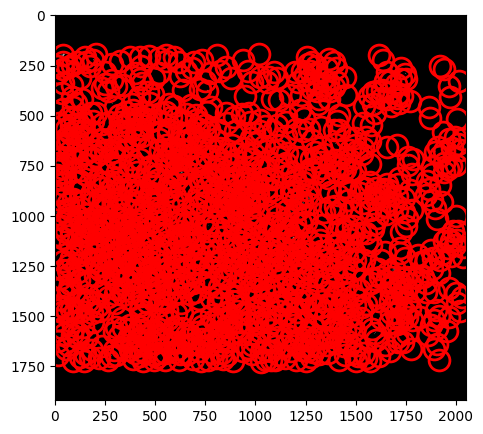

<Axes: >

In [5]:
f = tp.locate(frames[0], 21)
tp.annotate(f, frames[0])

/usr/local/lib/python3.11/site-packages/trackpy/plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()
/usr/local/lib/python3.11/site-packages/trackpy/plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

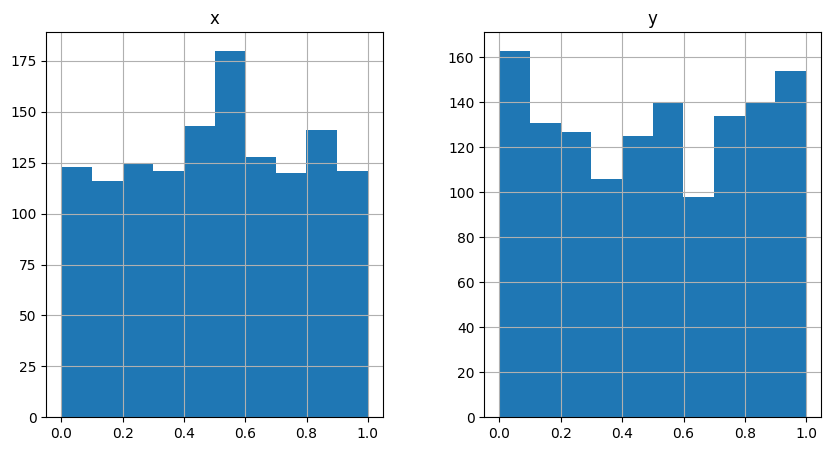

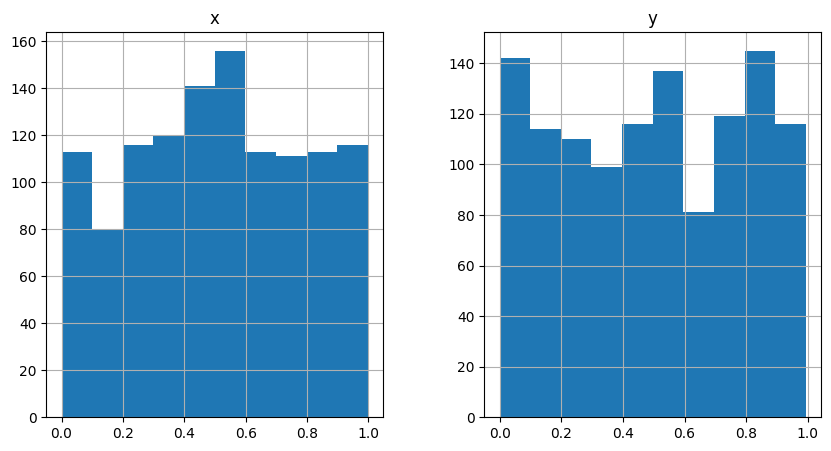

In [6]:
# Subpixel accuracy
tp.subpx_bias(f)
pixel_dia = 23
tp.subpx_bias(tp.locate(frames[0], pixel_dia))

In [7]:
f = tp.batch(frames[:100], pixel_dia, engine='numba',processes=1)

Frame 99: 1359 features


In [8]:
# STEP 3: LINK FEATURES INTO PARTICLE TRAJECTORIES
t = tp.link(f, 8, memory=4)

Frame 99: 1359 trajectories present.


Before: 63571
After: 687


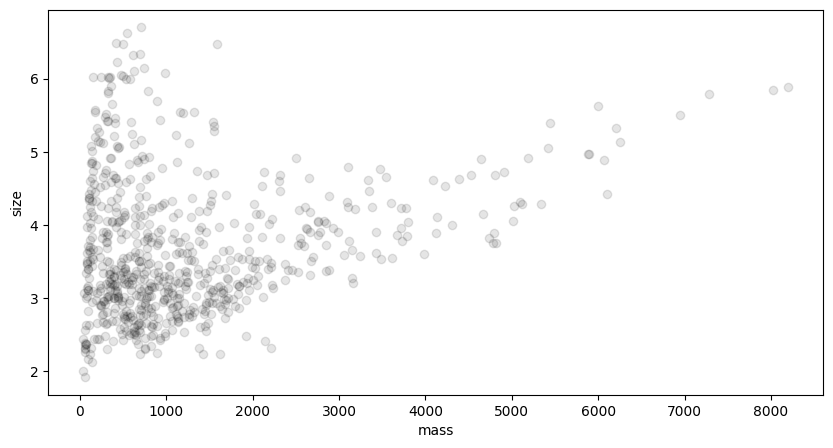

<Axes: xlabel='mass', ylabel='size'>

In [9]:
# Filter spurious trajectories
t1 = tp.filter_stubs(t, 10)

# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())
plt.figure()
tp.mass_size(t1.groupby('particle').mean()) # convenience function -- just plots size vs. mass

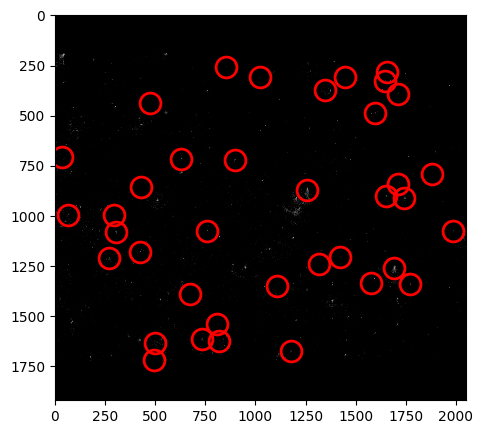

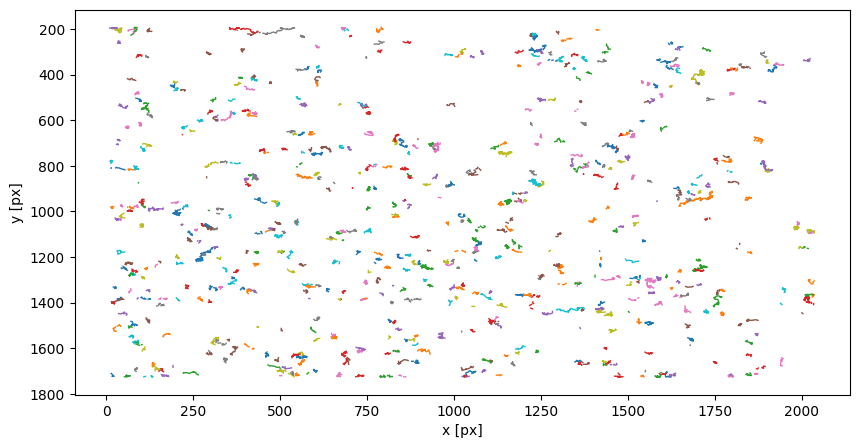

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [10]:
t2 = t1[((t1['mass'] > 50) & (t1['size'] < 8) & (t1['ecc'] < 0.5))]
plt.figure()
tp.annotate(t2[t2['frame'] == 0], frames[0])

plt.figure()
tp.plot_traj(t2)

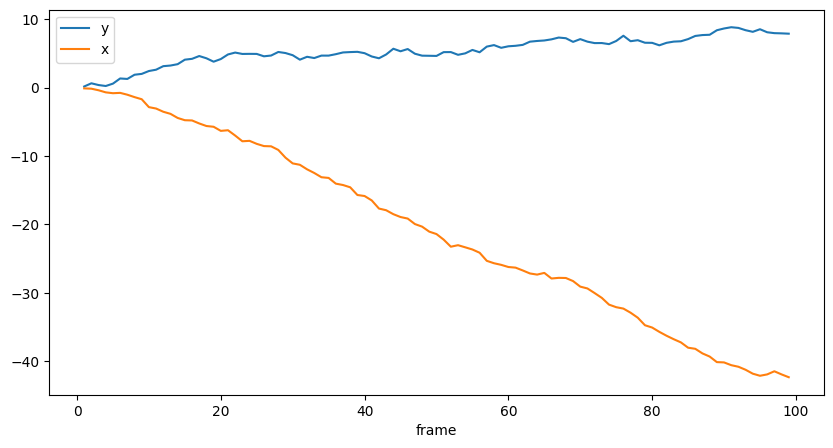

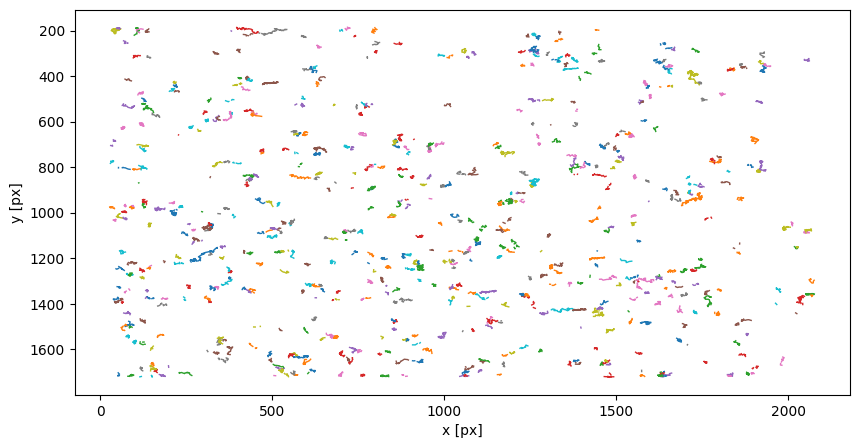

In [11]:
# Remove overall drift
d = tp.compute_drift(t2)
d.plot()
plt.show()

tm = tp.subtract_drift(t2.copy(), d)

ax = tp.plot_traj(tm)
plt.show()

In [12]:
# STEP 4: ANALYZE TRAJECTORIES
tm = tm.reset_index(drop=True)
mpp = 0.055 # microns per pixel
#im = tp.imsd(tm, mpp, 6.2) # microns per pixel = 0.055, frames per second = 6.2

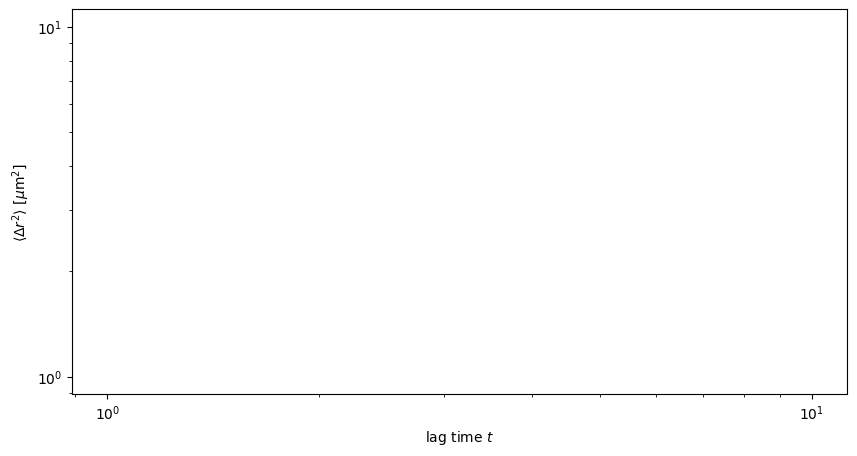

In [13]:
fig, ax = plt.subplots()
#ax.plot(im.index, im, 'k-', alpha=0.1) # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', 
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

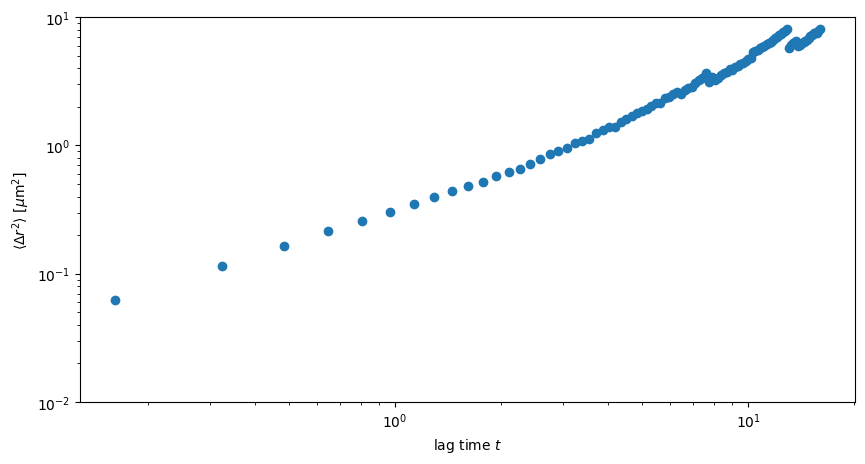

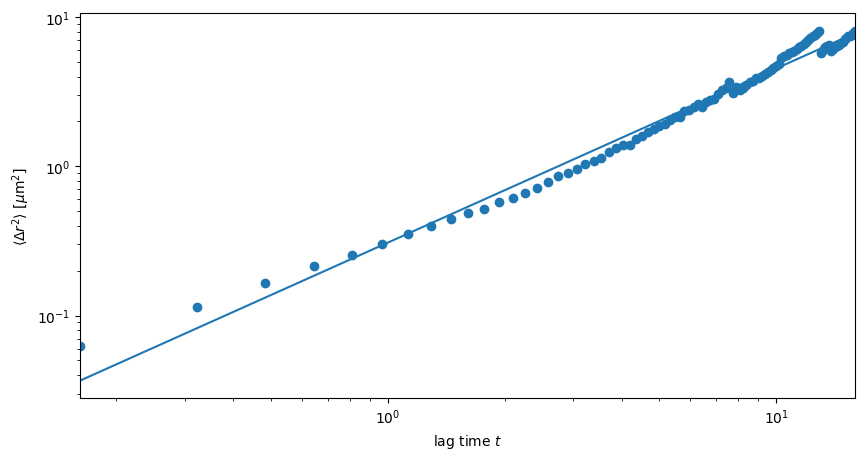

,n,A
msd,1.167295,0.307963


In [14]:
# Ensemble Mean Squared Displacement
em = tp.emsd(tm, mpp, 6.2) # microns per pixel = 100/285., frames per second = 24
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $t$')
ax.set(ylim=(1e-2, 10))

plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$')
tp.utils.fit_powerlaw(em) # performs linear best fit in log space, plots

In [15]:
# Find the optical radius
all_size_list_r = []  # To store radius lists for all frames
for frame in range(100):  # Loop through 100 frames to get better estimate
    size_list = t2["size"][frame].to_list() # Particle sizes current frame, use t2 for filter
    size_list_r = [elem / 2 * mpp for elem in size_list]  # Convert to radius in microns
    all_size_list_r.extend(size_list_r)  # Collect the radius list from all frames

# Save as CSV
df = pd.DataFrame(all_size_list_r)
df.to_csv('optical_radius_B1.csv', index=False)

# Now calculate the mean and standard deviation across all frames
r_optical = [f'{np.mean(all_size_list_r):.2e} \u00B1 {np.std(all_size_list_r):.2e}']


A_value = 0.307963 # Add all the decimals
D_value = A_value/4 #um^2/s
r_hyd = (293 * 1.38*10**-23) / (6 * np.pi * 10**-3 * D_value)

# Prepare the new values to replace
new_values = [f'{D_value:.2e}', f'{r_hyd:.2e}', r_optical]

# Check if the file exists and read existing rows
rows = {}
if os.path.exists('Lab_A_Data.csv'):
    with open('Lab_A_Data.csv', 'r', newline='') as f:
        reader = csv.reader(f)
        # Read the header row
        header = next(reader)
        # Store existing rows in a dictionary
        rows = {row[0]: row[1:] for row in reader}

# Replace the values in the specified row
rows['B1'] = new_values  # Replace or create the row

# Write all rows back to the CSV file
with open('Lab_A_Data.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    # Write the header row
    writer.writerow(['Row','Value D', 'r_hyd','r_optical'])
    # Write the data rows
    for row_name, values in rows.items():
        writer.writerow([row_name] + values)